In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_clean = pd.read_csv('/content/drive/MyDrive/Dissertation/clean_diabetes_data.csv')

with open('/content/drive/MyDrive/Dissertation/xgboost_model_results.json', 'r') as f:
    xgb_results = json.load(f)

with open('/content/drive/MyDrive/Dissertation/shap_results.json', 'r') as f:
    shap_results = json.load(f)

with open('/content/drive/MyDrive/Dissertation/xgboost_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open('/content/drive/MyDrive/Dissertation/xgboost_label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print(f"XGBoost accuracy: {xgb_results['test_accuracy']:.3f}")
print('Number of features: ', len(feature_names))
print('Diabetes classes: ', len(label_encoder.classes_))
print(f"Most important features: {shap_results['top_features'][:3]}")

XGBoost accuracy: 0.905
Number of features:  38
Diabetes classes:  13
Most important features: ['Blood Glucose Levels', 'Age', 'Weight Gain During Pregnancy']


In [6]:
X = df_clean[feature_names]
y_encoded = label_encoder.transform(df_clean['diabetes_type'])

selected_features = [feat for feat in shap_results['top_features'][:15] if feat in feature_names]
X_clustering = X[selected_features]

print("Top 10 features:", selected_features[:10])
print("Numeric features:", X_clustering.select_dtypes(include=[np.number]).shape[1])
print("Categorical features:", X_clustering.select_dtypes(include=['object', 'bool']).shape[1])

Top 10 features: ['Blood Glucose Levels', 'Age', 'Weight Gain During Pregnancy', 'Blood Pressure', 'Cholesterol Levels', 'BMI', 'Waist Circumference', 'Insulin Levels', 'Birth Weight', 'Digestive Enzyme Levels']
Numeric features: 10
Categorical features: 0


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print('Shape:', X_scaled.shape)

Shape: (70000, 10)


In [10]:
# Taken a sample of 20000 records as 70000 records were taking too long to process
X_sample = resample(X_scaled, n_samples=20000, random_state=42)

k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, cluster_labels))

optimal_k = k_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_k)
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

Optimal number of clusters: 2
Best silhouette score: 0.383


In [11]:
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.3f}")

Silhouette Score for k=2: 0.383
Silhouette Score for k=3: 0.338
Silhouette Score for k=4: 0.290
Silhouette Score for k=5: 0.276
Silhouette Score for k=6: 0.205
Silhouette Score for k=7: 0.203
Silhouette Score for k=8: 0.162
Silhouette Score for k=9: 0.139
Silhouette Score for k=10: 0.145
Silhouette Score for k=11: 0.144
Silhouette Score for k=12: 0.142
Silhouette Score for k=13: 0.117
Silhouette Score for k=14: 0.101
Silhouette Score for k=15: 0.101


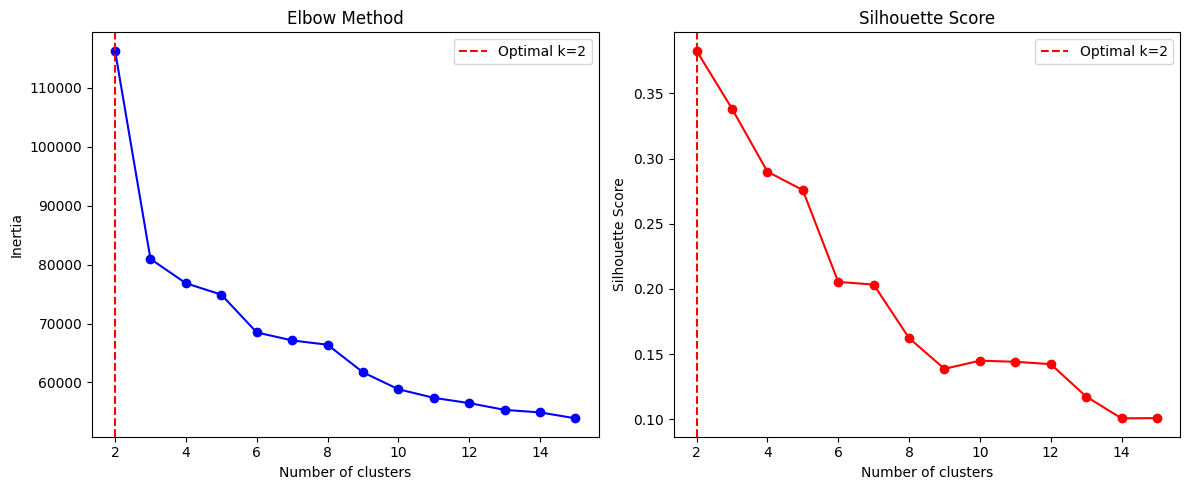

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elbow curve
ax1.plot(k_range, inertias, 'bo-')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax1.legend()

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(X_scaled)

df_clustered = df_clean.copy()
df_clustered['cluster'] = cluster_labels

silhouette = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette:.3f}")

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster distribution:")
for i, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {i}: {count} samples ({percentage:.1f}%)")

Silhouette Score: 0.351
Cluster distribution:
  Cluster 0: 23932 samples (34.2%)
  Cluster 1: 46068 samples (65.8%)


In [14]:
for cluster_id in range(optimal_k):
    cluster_data = X_clustering[cluster_labels == cluster_id]
    centroid = cluster_data.mean()
    dominant_type = df_clustered.loc[cluster_labels == cluster_id, 'diabetes_type'].mode().iloc[0]

    size = len(cluster_data)
    percentage = (size / len(cluster_labels)) * 100

    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {size} ({percentage:.1f}%)")
    print("  Dominant type: " + str(dominant_type))
    print("  Top features:")

    top_features = centroid.sort_values(ascending=False).head(3)
    for i, (feature, value) in enumerate(top_features.items(), 1):
        print(f"    {i}. {feature}: {value:.3f}")


Cluster 0:
  Size: 23932 (34.2%)
  Dominant type: neonatal diabetes mellitus (ndm)
  Top features:
    1. Birth Weight: 2488.406
    2. Blood Glucose Levels: 175.866
    3. Cholesterol Levels: 152.821

Cluster 1:
  Size: 46068 (65.8%)
  Dominant type: secondary diabetes
  Top features:
    1. Birth Weight: 3413.253
    2. Cholesterol Levels: 216.710
    3. Blood Glucose Levels: 152.824


Distribution (%):
cluster                                        0     1
diabetes_type                                         
cystic fibrosis-related diabetes (cfrd)      1.9  10.9
gestational diabetes                         0.1  11.5
lada                                         0.2  11.2
mody                                        11.5   6.1
neonatal diabetes mellitus (ndm)            22.6   0.0
prediabetic                                  0.0  11.7
secondary diabetes                           0.0  11.9
steroid-induced diabetes                     0.0  11.5
type 1 diabetes                             18.9   2.0
type 2 diabetes                              0.0  11.7
type 3c diabetes (pancreatogenic diabetes)   0.0  11.5
wolcott-rallison syndrome                   22.6   0.0
wolfram syndrome                            22.2   0.0


<Figure size 1200x600 with 0 Axes>

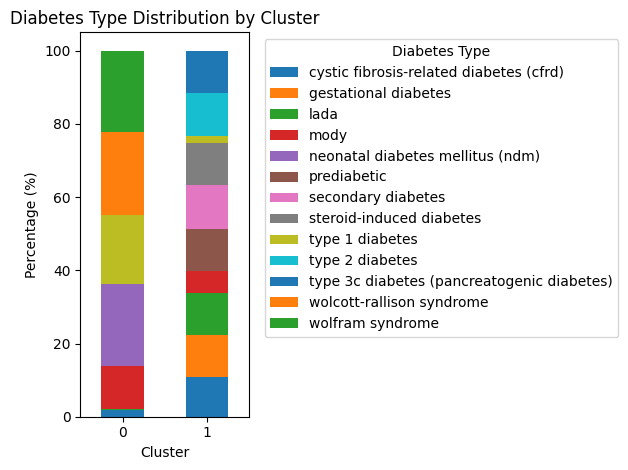

In [15]:
diabetes_distribution = pd.crosstab(
    df_clustered['diabetes_type'],
    df_clustered['cluster'],
    normalize='columns'
) * 100

print("Distribution (%):")
print(diabetes_distribution.round(1))

plt.figure(figsize=(12, 6))
diabetes_distribution.T.plot(kind='bar', stacked=True)
plt.title('Diabetes Type Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage (%)')
plt.legend(title='Diabetes Type', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"PCA explained variance: {explained_variance.sum():.3f}")

# t-SNE on a sample for efficiency
sample_size = min(5000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled[sample_indices])

print('t-SNE performed on ', sample_size, 'samples')

PCA explained variance: 0.711
t-SNE performed on  5000 samples


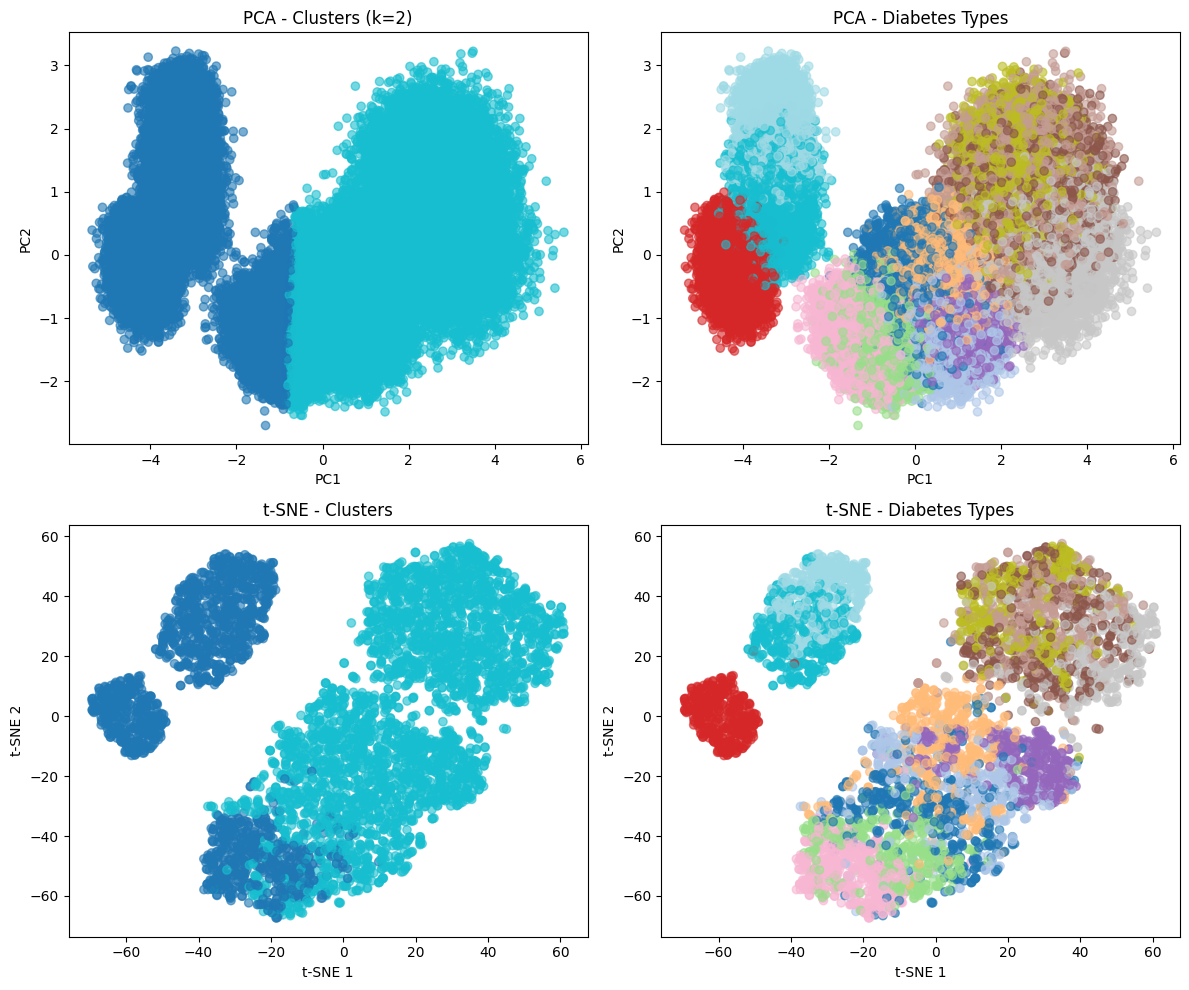

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# PCA - Clusters
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
ax1.set_title(f'PCA - Clusters (k={optimal_k})')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# PCA - Diabetes Types
diabetes_numeric = pd.Categorical(df_clustered['diabetes_type']).codes
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=diabetes_numeric, cmap='tab20', alpha=0.6)
ax2.set_title('PCA - Diabetes Types')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# t-SNE - Clusters
sample_cluster_labels = cluster_labels[sample_indices]
ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_cluster_labels, cmap='tab10', alpha=0.6)
ax3.set_title('t-SNE - Clusters')
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')

# t-SNE - Diabetes Types
sample_diabetes = pd.Categorical(df_clustered.iloc[sample_indices]['diabetes_type']).codes
ax4.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_diabetes, cmap='tab20', alpha=0.6)
ax4.set_title('t-SNE - Diabetes Types')
ax4.set_xlabel('t-SNE 1')
ax4.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [21]:
# Top SHAP features present in clustering
shap_features_used = [feat for feat in shap_results['top_features'][:10] if feat in selected_features]

cluster_means = X_clustering.groupby(cluster_labels).mean()

for feature in shap_features_used[:5]:
    print("\n" + feature + ":")

    feature_vals = cluster_means[feature]
    for cluster_id, val in feature_vals.items():
        print("  Cluster " + str(cluster_id) + ": " + str(round(val, 3)))

    max_cluster = feature_vals.idxmax()
    print("  Highest in Cluster " + str(max_cluster))


Blood Glucose Levels:
  Cluster 0: 175.866
  Cluster 1: 152.824
  Highest in Cluster 0

Age:
  Cluster 0: 10.188
  Cluster 1: 43.363
  Highest in Cluster 1

Weight Gain During Pregnancy:
  Cluster 0: 6.093
  Cluster 1: 20.382
  Highest in Cluster 1

Blood Pressure:
  Cluster 0: 91.608
  Cluster 1: 121.59
  Highest in Cluster 1

Cholesterol Levels:
  Cluster 0: 152.821
  Cluster 1: 216.71
  Highest in Cluster 1


In [22]:
cluster_assignments = df_clustered[['diabetes_type', 'cluster']].copy()
cluster_assignments.to_csv('/content/drive/MyDrive/Dissertation/cluster_assignments.csv', index=False)

with open('/content/drive/MyDrive/Dissertation/kmeans_model.pkl', 'wb') as f:
    pickle.dump(final_kmeans, f)

with open('/content/drive/MyDrive/Dissertation/clustering_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

clustering_results = {
    'optimal_k': optimal_k,
    'silhouette_score': float(silhouette_score(X_scaled, cluster_labels)),
    'selected_features': selected_features,
    'total_samples': len(X_clustering),
    'cluster_sizes': pd.Series(cluster_labels).value_counts().sort_index().to_dict()
}

with open('/content/drive/MyDrive/Dissertation/clustering_results.json', 'w') as f:
    json.dump(clustering_results, f, indent=2)

print("Files successfully saved!")

Files successfully saved!
